# Movie Analysis Project
**Authors:** Connor McClain & Cooper McCombs

# Overview

The movie business is a multibillion dollar industry that estimated to have made roughly 36.8 billion as of 2021. On average, movies made in the U.S tend to make around 373.2 million worldwide. While money is important, popularity and ratings are what sustain a business. If a company is popular, money will follow. Using Python, we extracted data from movie websites to produce models on what makes movies well-liked among the public. Sorting the data by genre, we were able to showcase the most popular genres and their characteristics. This notebook is expected to be used as refrence material for the creation of movies and specificaly Microsoft Movies Studios. 


# Introduction to the Problem

Microsoft is planning on creating a movie company and needs help to figure out what kinds of films they should produce. Using the data we found from IMDB (Internet Movie Database), TMDB (The Movie Database), and The Numbers website, we explored what types of movies were the most important to make. Then, proceeded to implement this data into graphs that conveyed the important traits of an average film. With this, we are able to portray to Microsoft that they should focus on popularity rather than profit.

# Data Understanding

We used the [Internet Movie Database(imdb)](https://www.imdb.com/), [The Movie Database(tmdb)](https://www.themoviedb.org/?language=en-US) and [The numbers(tn)](https://www.the-numbers.com/). These sources are usefull for this research due to these sources being well acredited movie databases.

# Data

 For this project, we used various sources of information to extract data that would represent my solution to Microsoft's problem. Then, we allocated this information on to different pandas dataframes based on its source. Not all data is clean and ready to go from the start. We had to remove all null values that would affect our models as well as clean through the columns of strings that we wanted to turn into integers (example: Production Budget). Our models correlated four different aspects of our solution for Microsoft: Genre based on highest average rating, genre based on highest average production budget, genre based on the ratio of the amount of movies already in that genre, and average runtime for each popular genre.

# Imports

In [64]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as lines
from matplotlib.ticker import StrMethodFormatter
import warnings

### Cleaning Warnings

In [65]:
warnings.filterwarnings("ignore")

## Importing Data

In [66]:
budgets_df = pd.read_csv("../dsc-phase-1-project-v2-4/zippedData/tn.movie_budgets.csv.gz", parse_dates=["release_date"])

In [67]:
tmdb_df = pd.read_csv("../dsc-phase-1-project-v2-4/zippedData/tmdb.movies.csv.gz", parse_dates=["release_date"])

In [68]:
conn = sql.connect("../dsc-phase-1-project-v2-4/im.db")

In [69]:
imdb_df = pd.read_sql("SELECT * FROM movie_basics", conn)

## Observing Imported Data

We can see in budgets_df that budget cleaned and turned into integers and if we want to merge with tmdb_df movie most be turned into title. There are 5782 rows 6 columns no nulls.

In [70]:
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [71]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In tmdb_df we must convert genre_ids string into a list then into the actual genres for better understanding. There are 26517 rows 10 columns no nulls.

In [72]:
tmdb_df.head(3)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


In [73]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26517 non-null  int64         
 1   genre_ids          26517 non-null  object        
 2   id                 26517 non-null  int64         
 3   original_language  26517 non-null  object        
 4   original_title     26517 non-null  object        
 5   popularity         26517 non-null  float64       
 6   release_date       26517 non-null  datetime64[ns]
 7   title              26517 non-null  object        
 8   vote_average       26517 non-null  float64       
 9   vote_count         26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.0+ MB


For the imdb_df we must explode the genres and removed the nulls from genres and runtime. There are 146144 rows 6 columns and 37168 nulls.

In [74]:
imdb_df.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


In [75]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


# Cleaning the Data

We need to clean budgets_df, tmdb_df and imdb_df by removing nulls in primary catagories and converting columns into an usable format. Which includes converting genre_ids, budget columns and removing excess columns.

### Genre Id to Genre

In [76]:
genre_id = {
    "Action" : 28,
    "Adventure" : 12,
    "Animation" : 16,
    "Comedy" : 35,
    "Crime" : 80,
    "Documentary" : 99,
    "Drama" : 18,
    "Family" : 10751,
    "Fantasy" : 14,
    "History" : 36,
    "Horror" : 27,
    "Music" : 10402,
    "Mystery" : 9648,
    "Romance" : 10749,
    "Science Fiction" : 878,
    "TV Movie" : 10770,
    "Thriller" : 53,
    "War" : 10752,
    "Western" : 37,
}

In [77]:
genre_id = {str(y):str(x) for x,y in genre_id.items()}

### Cleaning tmdb_df

In [78]:
tmdb_df_clean = tmdb_df.copy()

In [79]:
tmdb_df_clean["genre_ids"] = tmdb_df["genre_ids"].str.replace("]","").str.replace("[","").str.replace(",","").str.split(" ")
# We did this to convert the genre_ids from a string into a list

Now we only want movies from this data that have a vote count >= 1000

In [80]:
tmdb_df_clean = tmdb_df_clean.loc[tmdb_df_clean["vote_count"] >= 1000]

In [81]:
tmdb_df_clean_weighted_avg = tmdb_df_clean.explode(column="genre_ids")
# This was done to turn genre_ids from a list into strings

In [82]:
weighted_mean = lambda x: np.average(x, weights=tmdb_df_clean.loc[x.index, "vote_count"])

# Used to get a weighted vote average
weighted_avg = tmdb_df_clean.explode(column="genre_ids").groupby("genre_ids").agg(
    sum_vote_count=("vote_count", "sum"), 
    vote_weighted_mean=("vote_average", weighted_mean)).reset_index()

In [83]:
weighted_avg["genre_ids"] = weighted_avg["genre_ids"].map(genre_id)
# mapping to numbers to Genres

In [84]:
weighted_avg["count/vote_score"] = (weighted_avg["sum_vote_count"]/1000000) * weighted_avg["vote_weighted_mean"]
# Divided by 1000000 to keep numbers small

In [85]:
top = weighted_avg.sort_values("count/vote_score", ascending = False)

### Cleaning budgets_df

[Replace()](https://www.w3schools.com/python/ref_string_replace.asp) Where I found the replace function.


[Markdown hyperlinking](https://www.youtube.com/watch?v=tYtPOq3AkmM) Where I learned how to hyperlink.

In [86]:
movie_budgets_df_clean = budgets_df.copy()

In [87]:
movie_budgets_df_clean['worldwide_gross'] = movie_budgets_df_clean['worldwide_gross'].str.replace("$", "").str.replace(",", "").astype("int64")

In [88]:
movie_budgets_df_clean['production_budget'] = movie_budgets_df_clean['production_budget'].str.replace("$", "").str.replace(",", "").astype("int64")

### Cleaning budgets_df for merge with tmdb_df_clean

In [89]:
m1 = budgets_df.copy()

In [90]:
m1["title"] = budgets_df["movie"]
# This was done to better merge with tmdb_df_clean

In [91]:
m1 = m1.drop(columns=["id", "domestic_gross", "worldwide_gross", "movie"])
# This was done to better merge with tmdb_df_clean

### Merging budgets_df and tmdb_df_clean

In [92]:
gm_df = tmdb_df_clean.merge(m1, how="inner")

In [93]:
gm_df = gm_df.drop(columns=["Unnamed: 0", "id", "original_language", "original_title", "popularity", "release_date", "title"])
# Dropping unused columns

In [94]:
gm_genre_df = gm_df.explode("genre_ids")
# This was done to turn genre_ids from a list into strings

In [95]:
gm_genre_df["genre_ids"] = gm_genre_df["genre_ids"].map(genre_id)
# mapping to numbers to Genres

In [96]:
gm_genre_df["production_budget"] = gm_genre_df["production_budget"].str.replace("$","").str.replace(",","")
#cleaning money string to turn into int

In [97]:
gm_genre_df["production_budget"] = gm_genre_df["production_budget"].astype(int)
# turned into int

In [98]:
gm_genre_avg = gm_genre_df.groupby("genre_ids").mean().reset_index()
#Grouped to find mean

In [99]:
top_gm_genre_avg = gm_genre_avg.sort_values("production_budget", ascending = False)

### Cleaning TMDB into top 6

In [100]:
mpy = tmdb_df_clean.explode(column = "genre_ids").groupby(['genre_ids']).agg(
    movies_produced = ('id', 'count')).reset_index()
# This was done to turn genre_ids from a list into strings

In [101]:
top_6 = mpy.sort_values('movies_produced', ascending = False)
#sorting values

In [102]:
top_6['genre_ids'] = top_6['genre_ids'].map(genre_id)
# mapping to numbers to Genres

In [103]:
top_6['percent'] = top_6['movies_produced']/sum(top_6['movies_produced'])
top_6['percent'] = top_6['percent'] * 100
#Turning count to percent

### Cleaning IMDB

In [104]:
imdb_df_clean = imdb_df.copy()

In [105]:
imdb_df_clean = imdb_df.dropna(subset = ['runtime_minutes', 'genres'])
#dropping nulls

In [106]:
imdb_df_clean["genres"] = imdb_df_clean["genres"].str.replace(",", " ").str.split(" ")
#Fixing Genre id

In [107]:
imdb_df_clean = imdb_df_clean.explode(column = "genres").groupby("genres").mean().reset_index()
#Mapping Genre id from number to genres

In [108]:
top_6_avg_runtimes = imdb_df_clean.loc[(imdb_df_clean['genres'] == 'Drama') |
                 ( imdb_df_clean['genres'] == 'Action') |
                  (imdb_df_clean['genres'] == 'Comedy') |
                  (imdb_df_clean['genres'] == 'Thriller') |
                  (imdb_df_clean['genres'] == 'Adventure') |
                  (imdb_df_clean['genres'] == 'Sci-Fi')]
#List of top 6 genres

In [109]:
top_6_avg_runtimes = top_6_avg_runtimes.sort_values('runtime_minutes', ascending = False)
# ordering top 6

## Graph Lists

In [110]:
las = ["-$100 Million","$0", "$100 Million", "$200 Million", "$300 Million", "$400 Million"]

In [111]:
los = ["$0", "$20 Million", "$40 Million", "$60 Million", "$80 Million", "$100 Million", "$120 Million", "$140 Million"]

# Data Analysis

## .Describes() of clean data

In [112]:
top.describe()

,sum_vote_count,vote_weighted_mean,count/vote_score
count,1.800000e+01,18.000000,18.000000
mean,6.563988e+05,7.014843,4.553231
std,5.528923e+05,0.274382,3.823246
min,3.022000e+03,6.408173,0.020936
25%,1.959418e+05,6.877193,1.373326
50%,4.799885e+05,6.917266,3.333996
75%,1.045250e+06,7.208073,7.166967
max,1.717990e+06,7.447277,11.678210


In [113]:
top_gm_genre_avg.describe()

,vote_average,vote_count,production_budget
count,17.000000,17.000000,1.700000e+01
mean,6.695425,4136.395982,7.575077e+07
std,0.270252,1342.468959,3.567693e+07
min,6.110112,2460.617647,3.303483e+07
25%,6.543946,3173.692308,4.599930e+07
50%,6.635780,3639.187500,6.154843e+07
75%,6.903311,4892.395604,1.138788e+08
max,7.166667,7306.222222,1.354542e+08


In [114]:
mpy.describe()

,movies_produced
count,18.000000
mean,171.444444
std,137.357508
min,2.000000
25%,65.000000
50%,146.000000
75%,263.250000
max,478.000000


In [115]:
imdb_df_clean.describe()

,start_year,runtime_minutes
count,27.000000,27.000000
mean,2014.453718,85.749716
std,0.633254,17.296116
min,2012.986220,16.400000
25%,2014.224497,80.806988
50%,2014.311430,87.136697
75%,2014.505060,94.316355
max,2016.300000,117.000000


In [116]:
top_6_avg_runtimes.describe()

,start_year,runtime_minutes
count,6.000000,6.000000
mean,2014.364423,93.150477
std,0.110438,4.723604
min,2014.223693,85.782404
25%,2014.306788,91.390932
50%,2014.335922,94.100769
75%,2014.436983,94.333846
max,2014.523251,100.019729


## Graphs

[ax.tick_params()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.tick_params.html) Where I found ax.tick_params().

The Vote/Count Score Graph represents the relationship between genre type and vote count score, showing the six most popular genres. The popular genres are colored orange to show that they are different from the other genres and are used in all the graphs.

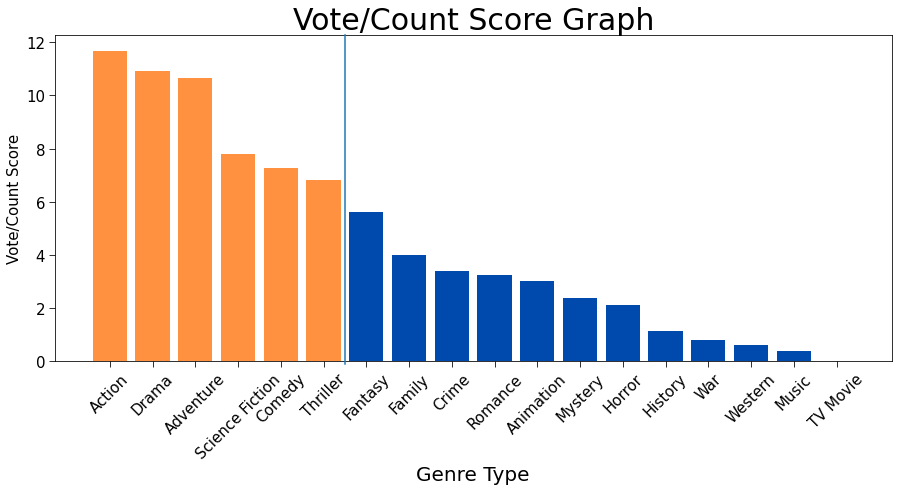

In [117]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.bar(x=top["genre_ids"], height=top["count/vote_score"], color=['#ff9140' if score > 6 else "#004aad" for score in top['count/vote_score']])

ax.set_xlabel("Genre Type", fontsize=20)
ax.set_ylabel("Vote/Count Score", fontsize=15)
ax.set_title("Vote/Count Score Graph", fontsize=30)
fig.add_artist(lines.Line2D([.3935, .3935], [.12, .88]))
plt.xticks(rotation=45)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/VoteCountScore.png", bbox_inches="tight")

Average Budget Cost per Genre represents the average production budget of the six most popular genres.

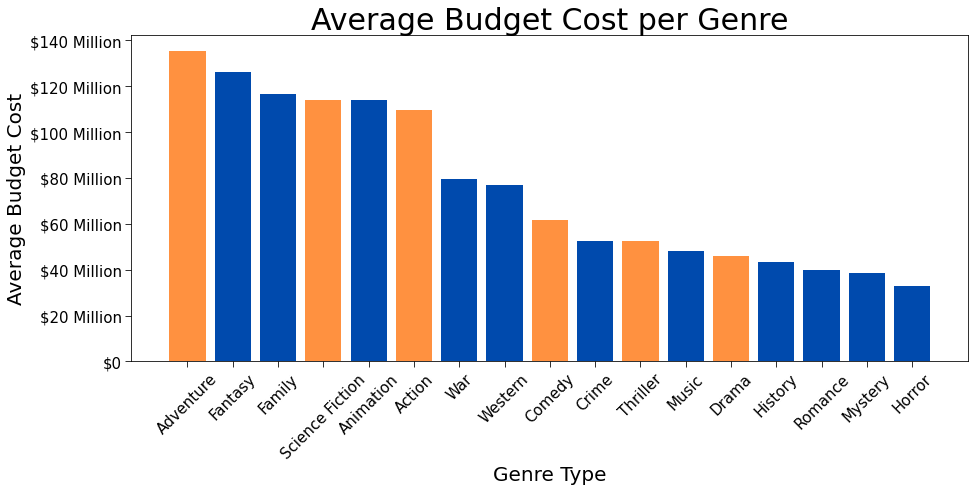

In [118]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.bar(x=top_gm_genre_avg["genre_ids"], height=top_gm_genre_avg["production_budget"], color=['#ff9140',"#004aad","#004aad",'#ff9140',"#004aad",'#ff9140',"#004aad","#004aad",'#ff9140',"#004aad",'#ff9140',"#004aad",'#ff9140',"#004aad","#004aad","#004aad","#004aad","#004aad"])

ax.set_xlabel("Genre Type", fontsize=20)
ax.set_ylabel("Average Budget Cost", fontsize=20)
ax.set_title("Average Budget Cost per Genre", fontsize=30)
ax.set_yticklabels(los, minor=False)
plt.xticks(rotation=45)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/Average_Budget_Cost_per_Genre.png", bbox_inches="tight")

Top 6 Most Popular Genres to Produce graph represents the amount of movies produced in each genre by percent.

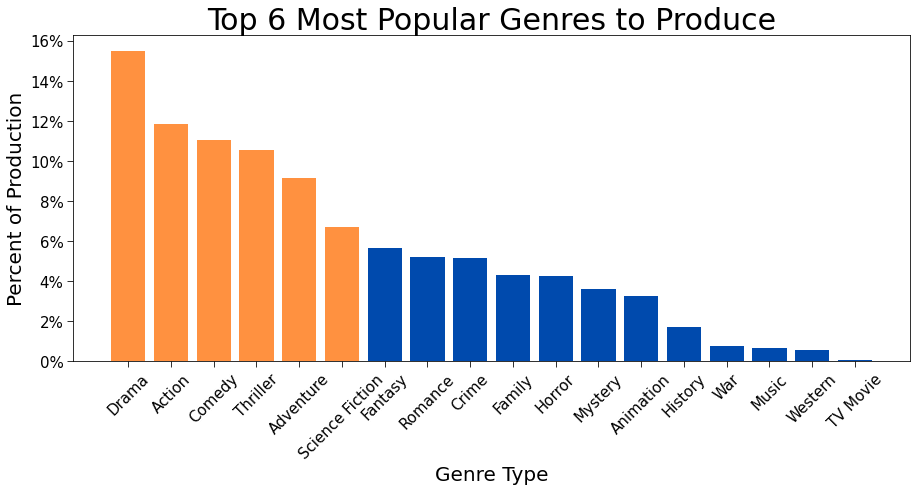

In [119]:
fig, ax = plt.subplots(figsize = (15, 6))
palette = plt.get_cmap('Set1')
ax.bar(top_6['genre_ids'], top_6['percent'], color = ['#ff9140' if percent > 6 else "#004aad" for percent in top_6['percent']])
ax.set_title("Top 6 Most Popular Genres to Produce", fontsize = 30)
ax.set_ylabel("Percent of Production", fontsize = 20)
ax.set_xlabel("Genre Type", fontsize = 20)
ax.tick_params(length = 6, which = ('both'))
plt.xticks(rotation = 45, fontsize=15)
plt.yticks(fontsize=15)
# ax.set_yticklabels(PV, minor = False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
plt.savefig("Graphs/Top_6_Most_Popular_Genres_to_Produce.png", bbox_inches="tight")
plt.show()

Genres by Average Runtime(minutes) graph represents the average runtime of each of the genres in popular genres.

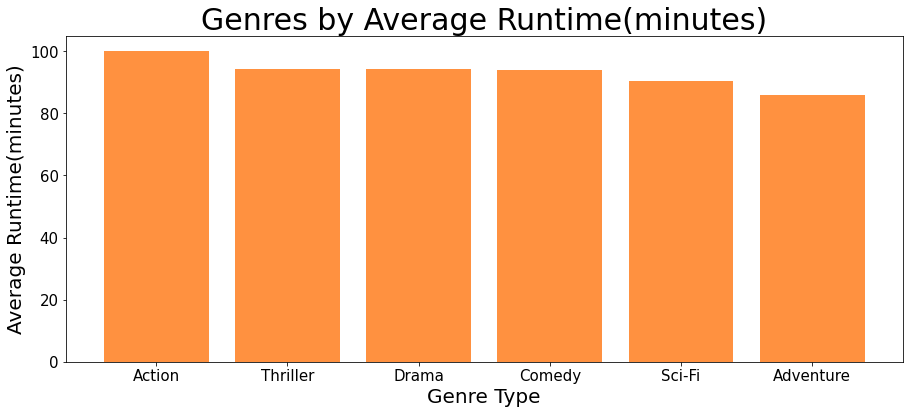

In [120]:
fig, ax = plt.subplots(figsize = (15, 6))
palette = plt.get_cmap('Set1')
ax.bar(top_6_avg_runtimes['genres'], top_6_avg_runtimes['runtime_minutes'], color = '#ff9140')
ax.set_title("Genres by Average Runtime(minutes)", fontsize=30)
ax.set_ylabel("Average Runtime(minutes)", fontsize=20)
ax.set_xlabel("Genre Type", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("Graphs/Genres_by_Average_Runtime(minutes).png", bbox_inches="tight")
plt.show()

Budget Cost per Average Vote graph shows that average vote is not strongly correlated with budget

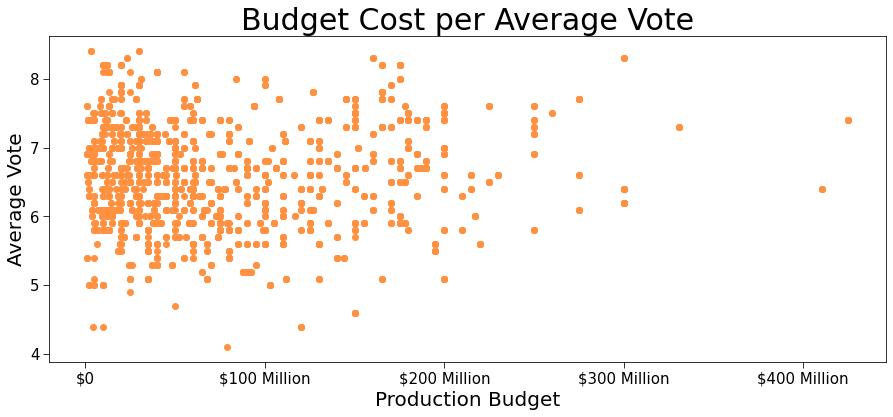

In [121]:
fig, ax = plt.subplots(figsize=(15,6))
palet =plt.get_cmap("Set1")
ax.scatter(y=gm_genre_df["vote_average"], x=gm_genre_df["production_budget"], color = '#ff9140')

ax.set_xlabel("Production Budget", fontsize=20)
ax.set_ylabel("Average Vote", fontsize=20)
ax.set_title("Budget Cost per Average Vote", fontsize=30)
ax.set_xticklabels(las, minor=False)
# ax.set_xticks(lis, minor=True)
# ax.set_xticklabels(lis, minor=True)
ax.tick_params(length=6, which="both", labelsize=15)
plt.savefig("Graphs/Budget_Cost_per_Average_Vote.png", bbox_inches="tight")

Correlation Between Budget and Gross graph shows that there is a strong positive correlation between budget and worldwide gross

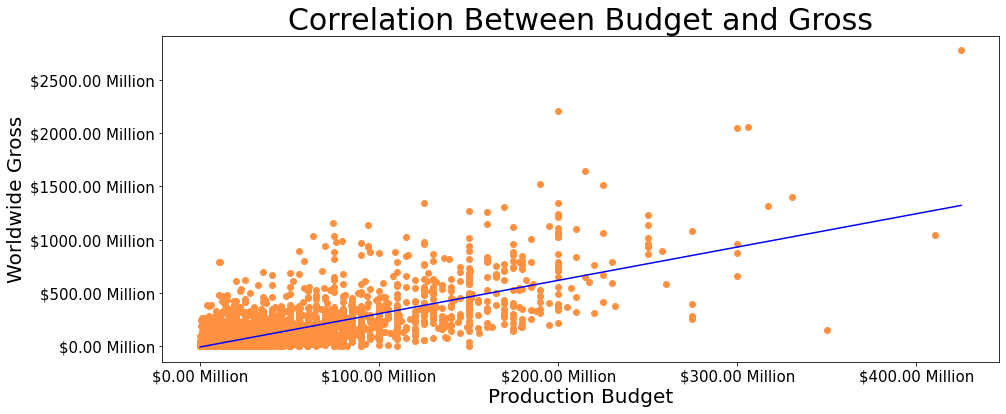

In [122]:
x = movie_budgets_df_clean['production_budget']/1000000
y = movie_budgets_df_clean['worldwide_gross']/1000000
palette = plt.get_cmap('Set1')
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(x, y, color = '#ff9140')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color = 'blue')
ax.set_title("Correlation Between Budget and Gross", fontsize = 30)
ax.set_ylabel("Worldwide Gross", fontsize = 20)
ax.set_xlabel("Production Budget", fontsize = 20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:.2f} Million'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:.2f} Million'))
plt.savefig("Graphs/Correlation_Between_Budget_and_Gross.png", bbox_inches="tight")
plt.show()

# Conclusion

From our data we were able to conclude:
- The top six most popular genres are: Action, Adventure, Comedy, Drama, Thriller, and Science Fiction
- That 67% of all movies Microsoft should produce should be at least one of the popular genres from above.
- Each movie should cost on average between $40 million and $140 million depending on the genre
- Each movie should be on average between 85 to 100 minutes long depending on the genre

These models give insight into how Microsoft should format their movies. By giving them the most popular genres and their average characteristics, Microsoft will be able to pick a genre and know how much it should cost, the frequency at which to make those movies, and around what runtime it should be.

# Future Work
We ran out of time, but some ideas we had to further our solution were:
- Comparing the popularity of adult rated movies to kid rated movies
- What are the best actors to use based on the genre of the movie
- What are the best directors based on the genre of the movie
comparing the popularity of a series of movies to a stand along movie
- Whether animated or real life films are more popular based on genre

# For More Information
- [Slide Presentation](https://github.com/Co-nn/Movie-Analysis-Project/blob/main/Cooper%20McCombs%20and%20Connor%20McClain.pdf)
- [Internet Movie Database (IMDB)](https://www.imdb.com/)
- [The Movie Database (TMDB)](https://www.themoviedb.org/?language=en-US)
- [The Numbers (TN)](https://www.the-numbers.com/)
- [How to Insert Hyperlinks](https://www.youtube.com/watch?v=tYtPOq3AkmM)
- [ax.tick_params()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.tick_params.html)
- [Replace()](https://www.w3schools.com/python/ref_string_replace.asp)